In [14]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

np.random.seed(0)


Problem 1

Here the OLS class is implemented in polynomial regression and statistical metrics of model quality are also constructed in order to understand how well our class works on arbitrary data


In [2]:
class PolynomialRegression:
  def __init__(self, degree):
    self.degree = degree
    self.coefs = None

  #known formula to estimate the parameters of the linear(polinomial regression model)
  def fit(self, X, y):
    X_poly = self._poly_features(X)
    self.coefs = np.linalg.inv(X_poly.T.dot(X_poly)).dot(X_poly.T).dot(y)


  def predict(self, X):
    X_poly = self._poly_features(X)
    return X_poly.dot(self.coefs)

  #in machine learning, fucntions of X (data) can be also features
  def _poly_features(self, X):
    X_poly = np.ones((X.shape[0], self.degree + 1))
    for i in range(0, self.degree + 1):
      X_poly[:, i] = X ** i
    return X_poly

  #metrics R^2 to determine the quality of the model
  def r_squared(self, X, y):
    y_pred = self.predict(X)
    ss_total = np.sum((y - np.mean(y)) ** 2)
    ss_res = np.sum((y - y_pred) ** 2)
    return 1 - (ss_res / ss_total)

  #statical p_value test method
  def p_values(self, X, y):
    X_poly = self._poly_features(X)
    y_pred = self.predict(X)
    residuals = y - y_pred
    s_squared = np.sum(residuals**2) / (X_poly.shape[0] - X_poly.shape[1])
    var_b = s_squared * np.linalg.pinv(X_poly.T.dot(X_poly)).diagonal()
    se_b = np.sqrt(var_b)
    t_stats = self.coefs / se_b
    p_values = [2 * (1 - stats.t.cdf(np.abs(t), X_poly.shape[0] - X_poly.shape[1])) for t in t_stats]
    return np.array(p_values), t_stats






Visualize at p=1, 2, 3, 5, 19, 25 degrees




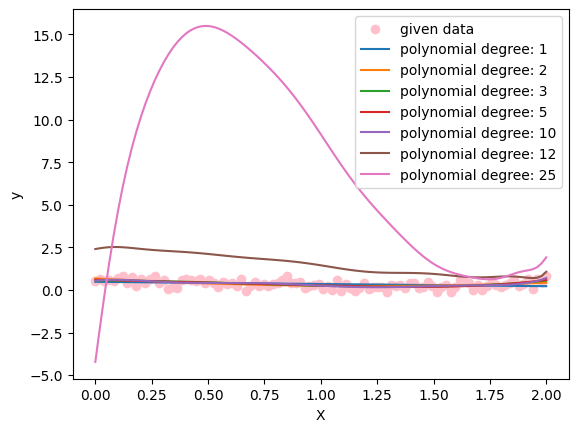

In [5]:
def read_data(file_path):
  data = pd.read_csv(file_path)
  del data['Unnamed: 0']
  data.columns = ['X', 'Y']
  return data['X'].values, data['Y'].values

if __name__ == "__main__":
  #reading data from csv file
  X, y = read_data('/content/task1.csv')

  #list of the polynomial degrees
  degrees = [1, 2, 3, 5, 10, 12, 25]

  plt.scatter(X, y, color='pink', label='given data')

  x_range = np.linspace(min(X), max(X), 100)

  #loop in degree values
  for degree in degrees:
    model = PolynomialRegression(degree=degree)
    model.fit(X, y)
    y_pred = model.predict(x_range)
    plt.plot(x_range, y_pred, label = f'polynomial degree: {degree}')

  plt.xlabel('X')
  plt.ylabel('y')
  plt.legend()
  plt.show()


There is a lot of anomalous data; we need to check our data for the presence of inhomogeneities and heterodecadicity. It can be seen that as the degree of the polynomial increases, the quality of the approximation noticeably deteriorates, which is due to the great complexity of our model. Below (in Problem 2) it will be shown that estimates of the coefficients of the 25 degree polynomial will be biased. It would also be interesting to estimate the amount of variance that may differ from the quality of the model and its adequacy to the application of our data.

Problem 2

In [7]:
if __name__ == "__main__":
  degree = 25
  X, y = read_data('/content/task1.csv')
  model = PolynomialRegression(degree=degree)
  model.fit(X, y)

  #p-value for our data
  p_values, t_stats = model.p_values(X, y)

  #check the hypothesis for the estimated coeficients for theta_k при k >= 10
  alpha = 0.05
  significant_coefs = []

  for k in range(10, degree + 1):
    if p_values[k] < alpha:
      significant_coefs.append((k, p_values[k], t_stats[k], model.coefs[k]))

  #the results output
  if significant_coefs:
    print('The hypothesis is rejected for the following coefficients (k, p-value, t-statistic, coefficient):')
    for coeficient in significant_coefs:
      print(coeficient)
  else:
    print("The hypothesis is not rejected for all coefficients k >= 10")


The hypothesis is rejected for the following coefficients (k, p-value, t-statistic, coefficient):
(10, 0.0, -10456.797112170909, -3328.6715569474195)
(11, 0.0, -3822.26042204341, -1676.4677754516986)
(12, 0.0, 2941.4561435033957, 1457.6327733114433)
(13, 0.0, -605.9404469101461, -275.0114148660935)
(14, 0.0, -151.29478647278913, -45.944051239139036)
(15, 0.0, -233.7716290869883, -28.31823977361514)
(16, 0.0, 341.4286231688442, 95.43033320797899)
(17, 0.0, -14.525946192785412, -6.654198406670037)
(18, 0.0, -103.8390503856619, -44.36887518966208)
(19, 0.0, 19.220802240805835, 2.711781625152674)
(20, 0.0, 37.970270437353356, 12.918274378177184)
(22, 0.0, -20.21796249969443, -1.3013723636579062)


As it is worth noting, many coefficients are biased, which reflects the fact that this model is least suitable for approximation.

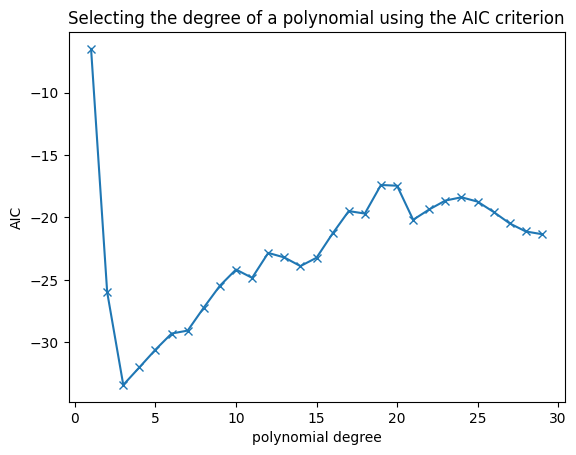

optimal degree: 3


In [10]:
np.random.seed(0)
X, y = read_data('/content/task1.csv')
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

#dividing the sample into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

aic_values = []
#I run the model through powers from 1 to 30, and check their AIC
for degree in range(1, 30):
  poly = PolynomialFeatures(degree)
  X_poly_train = poly.fit_transform(X_train)
  X_poly_test = poly.transform(X_test)

  model = sm.OLS(y_train, X_poly_train).fit()
  y_pred = model.predict(X_poly_test)

  aic = model.aic
  aic_values.append(aic)

optimal_degree = np.argmin(aic_values) + 1


plt.plot(range(1, 30), aic_values, marker='x')
plt.xlabel('polynomial degree')
plt.ylabel('AIC')
plt.title('Selecting the degree of a polynomial using the AIC criterion')
plt.show()

print(f'optimal degree: {optimal_degree}')

As you can see, here the optimal degree will be 3, these results were obtained using the built-in functions of the Python language. Regarding the obtained result, we can say that indeed, as shown in the figure, starting from deg p > 5, AIC monotonic growth occurs, and the global minimum corresponds to the most suitable degree of the polynomial for approximation.

Let's move on to task 2

In [12]:
data = pd.read_csv('/content/task2.csv')
data.head()



,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


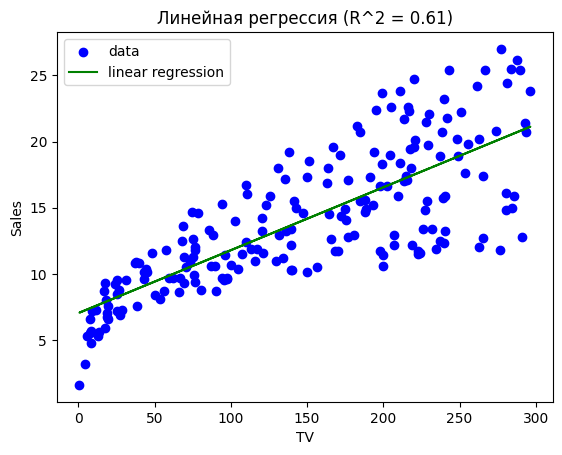

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Sun, 14 Jul 2024   Prob (F-statistic):           1.47e-42
Time:                        11:47:45   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0326      0.458     15.360      0.0

In [17]:
# Only two values ​​were selected from the dataframe, which is required for the task conditions.
X = data['TV'].values.reshape(-1, 1)
y = data['Sales'].values.reshape(-1, 1)


model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# R^2 score calculation
r2 = r2_score(y, y_pred)

# display the results on a graph
plt.scatter(X, y, color='blue', label='data')
plt.plot(X, y_pred, color='green', label='linear regression')
plt.xlabel('TV')
plt.ylabel('Sales')
plt.legend()
plt.title(f'Линейная регрессия (R^2 = {r2:.2f})')
plt.show()

# Проверка значимости коэффициента
X_with_const = sm.add_constant(X)
model_sm = sm.OLS(y, X_with_const).fit()
print(model_sm.summary())


As you can see, visually, linear regression is not very suitable for our data, since as TV increases, Sales does not increase evenly, but with a large error, which means that our data is not homogeneous, and as a result, homodecadicity is violated, and therefore the regression model is not particularly applicable to our data, however, although the coefficient of determination is 0.61, it is not too close to zero and not too far from 1, which can tell us that a linear trend can still give us some predictions , but with low accuracy.
---



We will now consider the logarithm of the data to check whether there will be changes in the direction of increasing the quality of the approximation


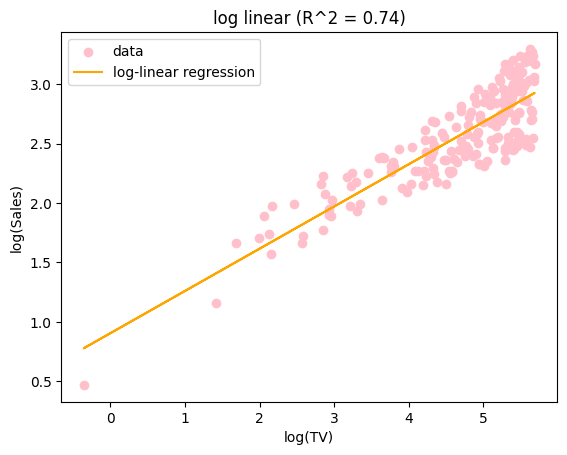

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     569.8
Date:                Sun, 14 Jul 2024   Prob (F-statistic):           3.51e-60
Time:                        11:52:33   Log-Likelihood:                 28.454
No. Observations:                 200   AIC:                            -52.91
Df Residuals:                     198   BIC:                            -46.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9052      0.071     12.737      0.0

In [20]:

# log data
log_X = np.log(data['TV'].values).reshape(-1, 1)
log_y = np.log(data['Sales'].values)

# log-linear model construction
model_log = LinearRegression()
model_log.fit(log_X, log_y)
log_y_pred = model_log.predict(log_X)

# determining R^2 score
r2_log = r2_score(log_y, log_y_pred)

#plotting
plt.scatter(log_X, log_y, color='pink', label='data')
plt.plot(log_X, log_y_pred, color='orange', label='log-linear regression')
plt.xlabel('log(TV)')
plt.ylabel('log(Sales)')
plt.legend()
plt.title(f'log linear (R^2 = {r2_log:.2f})')
plt.show()

# check the significance of our model
log_X_with_const = sm.add_constant(log_X)
model_log_sm = sm.OLS(log_y, log_X_with_const).fit()
print(model_log_sm.summary())




Based on the visualization, the model has indeed become better, and the coefficient of determination also speaks about this; it has become closer to 1. Also, after logarithm, our data were grouped and became more homogeneous than they were before. However, we can conclude that the regression model has become better (however, there are outliers)

Let's move on to the last point of the second task. We transform the data so that everything fits the task conditions

In [22]:
data['log_TV'] = np.log(data['TV'])
data['log_Sales'] = np.log(data['Sales'])

X = data[['log_TV', 'Radio', 'Newspaper']]
y = data['log_Sales']

Based on new features and answers, we will train regression, semi-logarithmic, semi-linear

In [25]:
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
r2

0.9730806537777336

As you can see, the coefficient of determination has become about 1, which means the gud model works

In [28]:
conf_int = model_sm.conf_int(alpha=0.05)
conf_int

array([[6.12971927, 7.93546783],
       [0.04223072, 0.05284256]])

Here, as we see above, confidence intervals for log-linear regression coefficients are shown. It is worth saying that the built-in fit function automatically adds a constant attribute

In [30]:
#params of the hypothesis
alpha_0, beta_0 = 4, 12
alpha_1, beta_1 = 3, 12

intervals = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7)]
frequencies = [61, 208, 167, 50, 13, 1]
n = sum(frequencies)

def theoretical_freq(alpha, beta, intervals, n):
    probs = [stats.gamma.cdf(b, alpha, scale=1/beta) - stats.gamma.cdf(a, alpha, scale=1/beta) for a, b in intervals]
    return [p * n for p in probs]

#H0 и H1
E_0 = theoretical_freq(alpha_0, beta_0, intervals, n)
E_1 = theoretical_freq(alpha_1, beta_1, intervals, n)

def likelihood_ratio(obs_freq, exp_freq_0, exp_freq_1):
    ratio = 0
    for o, e0, e1 in zip(obs_freq, exp_freq_0, exp_freq_1):
        if o > 0 and e0 > 0 and e1 > 0:
            ratio += o * np.log(e0 / e1)
    return -2 * ratio

LR = likelihood_ratio(frequencies, E_0, E_1)

critical_value = stats.chi2.ppf(1 - 0.017, df=1)

(LR, critical_value)


(-1903.4730666638593, 5.696373809885132)